**Generate data for model training**

In [3]:
import copy
import numpy as np
from scipy import signal
from scipy.special import wofz, erf
import matplotlib.pyplot as plt
import notebook
from tqdm.auto import tqdm
import random
import os
import pandas as pd

Functions to generate elementary signals

In [4]:
def gauss(x, c0, fwhm0):
    '''Gaussian distrubution at point x; centered at c0 with full width half maximum of fwhm0
      Ref: http://hyperphysics.phy-astr.gsu.edu/hbase/Math/gaufcn.html#c1'''
    
    sigma = fwhm0 / 2.355
    gauss_x =  (1/np.sqrt(2 * np.pi * sigma * sigma)) * np.exp(- (x - c0) *
                                                                 (x - c0) / (2 * sigma * sigma))
    #print(c0)
    return gauss_x


def lorentz(x, c0, fwhm0):
    '''Lorentzian distrubution at point x; centered at c0 with full width half maximum of fwhm0
    Ref: https://en.wikipedia.org/wiki/Cauchy_distribution'''
 
    gamma = fwhm0 / 2
    lorentz_x = (1 / (np.pi * gamma)) * ( (gamma ** 2) / ((x - c0) ** 2 + gamma ** 2))

    return lorentz_x


def gauss_array(low_e, c0, chnl_e, fwhm0, array_len):
    ''' An array contain a Gaussian distrubution 
    low_e: the lower-band energy
    chnl_e: the energy channels in the array
    fwhm0: FWHM of the quasi-Dirac distribution'''
 
    high_e = low_e + chnl_e * (array_len-1)
    gauss_ar = np.linspace(low_e, high_e, num= array_len)

    for i in range(array_len):
        gauss_ar[i] = gauss(gauss_ar[i], c0, fwhm0)

    return gauss_ar


def lorentz_array(low_e, c0, chnl_e, fwhm0, array_len):
    ''' An array contain a Gaussian distrubution 
    low_e: the lower-band energy
    chnl_e: the energy channels in the array
    c0: center of the  (eV)
    fwhm0: FWHM of the quasi-Dirac distribution'''

    high_e = low_e + chnl_e * (array_len-1)
    lorentz_ar = np.linspace(low_e, high_e, num= array_len)

    for i in range(array_len):
        lorentz_ar[i] = lorentz(lorentz_ar[i], c0, fwhm0)

    return lorentz_ar


def convolve_1d(x1, x2):
    '''Covolves signal x1 with signal x2 (psf)'''

    conv_output = np.convolve(x1, x2, mode = 'same')
    
    return conv_output


def normal_integration(x):
    ''' Normalizes the array x to its integral'''

    integral_x = 0

    for i in range (len(x)): 
        integral_x += x[i] 

    x_norm = x / integral_x

    return x_norm


def noise(amplitude, dark_noise_level, array_len):
    ''' Random noise following a normal distribution'''
    
    return np.random.normal(loc = dark_noise_level, scale = amplitude, size = array_len)

Function to generate a set of signal with physical parameters

In [33]:
def signal_set(num, low_e, chnl_e, fwhm0, array_len, wobble = 0.01):
    
    #Arrays containing simulated signals: 
    sim_signal = np.zeros((num, array_len))
    sim_conv_signal = np.zeros((num, array_len))
    peaks_loc = np.zeros((num, array_len))
    
    # low_e = -2 
    psf_max_fwhm = 0.2*10     #eV
    psf_min_fwhm = 0.035*10   #eV
    
    zlp_c0 = 0              #eV
    lrz_max_loc = 8         #eV
    lrz_min_loc = 0.05      #eV
    
    
    lrz_max_fwhm = 1.5*10      #eV
    lrz_min_fwhm = 0.05*10     #eV

    lrz_max_ratio = 4000*0.01    #eV
    lrz_min_ratio = 300*0.01     #eV

    noise_max_amp = 1e-3*100    #eV
    noise_min_amp = 1e-8*100    #eV
    noise_dark_level = 1e-7*100 #eV

    peak_num_max = 15
    peak_num_min = 0 
    
    wobble_num_max = 25
    
    #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    #Dataframe holding  information about the peaks in the in the simulated signal
    #info_peak_loc = np.zeros((num,peak_num_max))
    #info_peak_fwhm = np.zeros((num,peak_num_max))
    #info_peak_ampl = np.zeros((num,peak_num_max))
    
    #info_noise_ampl = np.zeros(num)
    #info_noise_dark = np.zeros(num)
    
    #info_psf_fwhm = np.zeros(num)
    #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    #Starting signal generation:
    for j in tqdm(range(len(sim_signal))):
        peak_num = random.randint(peak_num_min, peak_num_max)
        wobble_num = wobble_num_max
        wobble_e = np.random.rand(wobble_num) * (2 * wobble) - wobble 
        wobble_e[0] = 0
        G = np.zeros((wobble_num, array_len))

        # Quasi-Dirac peak is simulated using a gaussian:
        for w in range(wobble_num):
            G[w] = gauss_array(low_e, wobble_e[w], chnl_e, fwhm0, array_len)
            G[w] = G[w] / np.max(G[w])
            sim_conv_signal[j] += G[w]
            
        sim_signal[j] += G[0]
        
        # Lorentzian peaks are added to the signal
        for p in range(peak_num):
            #Set the center of lorentzian peak
            lrz_peak_loc = random.randint(int(-low_e / chnl_e), array_len - 2 ) # forcing peaks to not happen befor zlp and also in the last 2 pixels of the array 
            lrz_c0 = lrz_peak_loc * chnl_e + low_e
            
            #Keep the location of lorentzian peak for lateral learnings
            #peaks_loc[j,lrz_peak_loc] = 1
            
            #Setting the fwhm of the lorentzian peak
            lrz_fwhm0 = (np.random.rand() * (lrz_max_fwhm - lrz_min_fwhm)) + lrz_min_fwhm
            lrz_ratio = (np.random.rand() * (lrz_max_ratio - lrz_min_ratio)) + lrz_min_ratio
            
            #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
            #Saving the information regarding the peaks 
            #info_peak_loc[j, p] = lrz_c0
            #info_peak_fwhm[j, p] = lrz_fwhm0
            #info_peak_ampl[j, p] = lrz_ratio
            #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
            
            #Wobbeling Lorentzian peaks similar to the Gaussian ZLP
            L = np.zeros((wobble_num, array_len))
            for ww in range(wobble_num):
                L[ww] = lorentz_array(low_e, lrz_c0 + wobble_e[ww], chnl_e, lrz_fwhm0, array_len)
                L[ww] = L[ww] / (np.max(L[ww]) * lrz_ratio)
                sim_conv_signal[j] += L[ww]
                #plt.plot(L[ww])
            sim_signal[j] += L[0]
            
            
        sim_signal[j] = normal_integration(sim_signal[j])
        sim_conv_signal[j] = normal_integration(sim_conv_signal[j])
        
        psf_fwhm0 = (np.random.rand() * (psf_max_fwhm - psf_min_fwhm)) + psf_min_fwhm
        psf_pxl = array_len - 1 # int(abs(low_e) * 2 / chnl_e) +1
        psf_low_e = int(psf_pxl / 2) * (-1 * chnl_e) 
        psf_signal = lorentz_array(psf_low_e, wobble_e[0],  chnl_e, psf_fwhm0, psf_pxl) 
        
        #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        #Saving the information regarding the psf 
        #info_psf_fwhm[j] = psf_fwhm0
        #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

        sim_conv_signal[j] = normal_integration(convolve_1d(sim_conv_signal[j], psf_signal))
        peak_max = np.max(sim_conv_signal[j])

        # adding dark and high frequenncy noise to the signals:
        noise_ampl = (np.random.rand() * (noise_max_amp - noise_min_amp) + noise_min_amp) * peak_max
        noise_dark = np.random.rand() * noise_dark_level
        sim_conv_signal[j] += noise(noise_ampl, noise_dark, array_len)
        
        #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        #Saving the information regarding the psf 
        #info_noise_ampl[j] = noise_ampl
        #info_noise_dark[j] = noise_dark
        #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    return sim_signal, sim_conv_signal


Generation of 6000 different signals with a energy dispersion of 5 meV, an energy resolution of 15 meV, 2048 channels, starting from -2 eV and an energy wobble of 50 meV (typical conditions for high resolution EELS spectra)

In [4]:
signal, conv = signal_set(6000,-2, 0.005, 0.015, 2048, 0.05)
print("---------------- Signal generation done !!! ----------------------")

  0%|          | 0/6000 [00:00<?, ?it/s]

---------------- Signal generation done !!! ----------------------


In [34]:
#trainig for our data

signal, conv = signal_set(100,-9, 0.037, 0.5, 2048, 0.05)
print("---------------- Signal generation done !!! ----------------------")


  0%|          | 0/100 [00:00<?, ?it/s]

---------------- Signal generation done !!! ----------------------


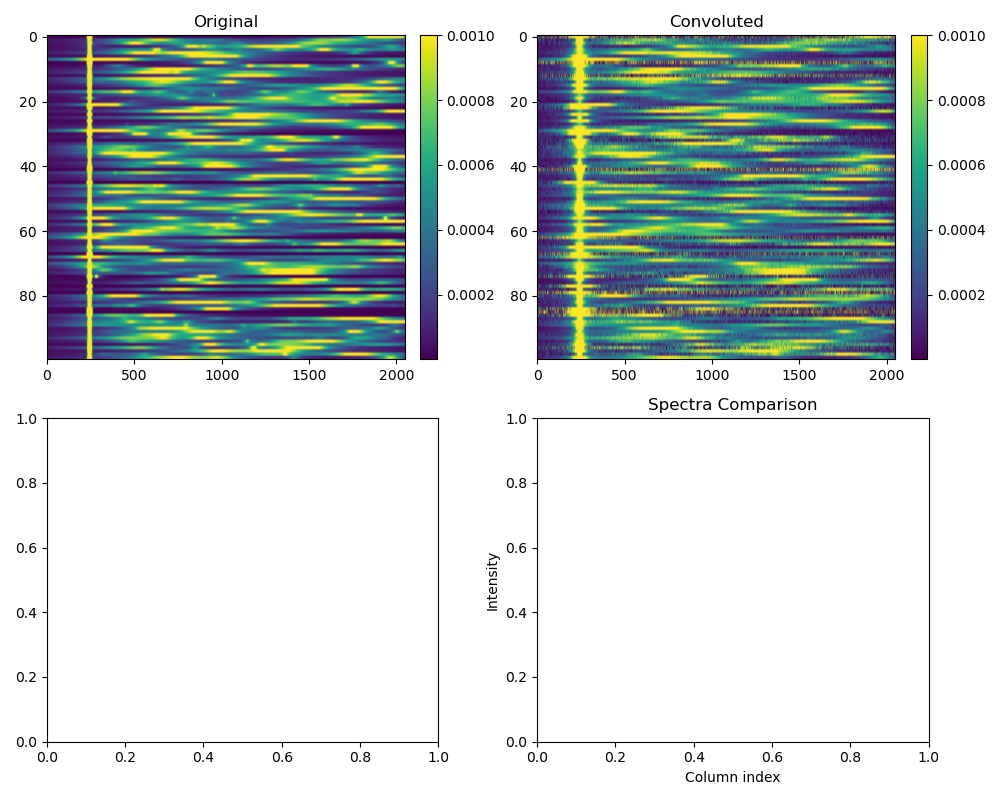

In [35]:
plot_interactive_spectra(signal, conv, vminVal=1e-6, vmaxVal=1e-3)

In [10]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

# # Example data if you want to test
# original = np.random.rand(2000, 2048)
# conv = np.random.rand(2000, 2048)
# prediction = np.random.rand(2000, 2048)

def plot_interactive_spectra(original, conv, vminVal=0.001, vmaxVal=0.0015):

    """
    Display 2D array images and enable interactive row selection for spectral comparison.

    Parameters
    ----------
    original : np.ndarray
        A 2D numpy array representing the original data (e.g., shape (rows, columns)).
        
    conv : np.ndarray
        A 2D numpy array representing the convoluted data (same shape as `original`).
        
    vminVal : float, optional
        Minimum value for colormap normalization (default is 0.001).
        
    vmaxVal : float, optional
        Maximum value for colormap normalization (default is 0.0015).

    Description
    -----------
    This function plots the three 2D arrays (original, convoluted, prediction) 
    as images in a 2x2 grid of subplots. The bottom-right subplot displays 
    the spectral comparison (row data from all three arrays) at a user-selected row.
    
    Clicking on any of the 2D image plots updates the spectra plot 
    for the corresponding row.

    Notes
    -----
    Requires `%matplotlib widget` (ipympl) in Jupyter for interactivity.
    """
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    ims = []
    ims.append(axs[0, 0].imshow(original, vmin=vminVal, vmax=vmaxVal, aspect='auto'))
    axs[0, 0].set_title('Original')
    fig.colorbar(ims[0], ax=axs[0, 0], fraction=0.046, pad=0.04)

    ims.append(axs[0, 1].imshow(conv, vmin=vminVal, vmax=vmaxVal, aspect='auto'))
    axs[0, 1].set_title('Convoluted')
    fig.colorbar(ims[1], ax=axs[0, 1], fraction=0.046, pad=0.04)

    axs[1, 1].set_title('Spectra Comparison')
    axs[1, 1].set_xlabel('Column index')
    axs[1, 1].set_ylabel('Intensity')

    plt.tight_layout()

    def onclick(event):
        if event.inaxes in axs.flatten() and event.ydata is not None:
            y = int(event.ydata)
            print(f"Selected row: {y}")

            x_vals = np.arange(original.shape[1])
            axs[1, 1].cla()

            axs[1, 1].plot(x_vals, original[y, :], label='Original')
            axs[1, 1].plot(x_vals, conv[y, :], label='Convoluted')
            axs[1, 1].plot(x_vals, prediction[y, :], label='Prediction')

            axs[1, 1].set_title(f'Spectra at row {y}')
            axs[1, 1].set_xlabel('Column index')
            axs[1, 1].set_ylabel('Intensity')
            axs[1, 1].set_yscale('log')
            axs[1, 1].legend()
            axs[1, 1].grid(True)

            fig.canvas.draw_idle()

    fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()




Save the generated data for further model training

In [5]:
## test model
np.save("original_general_6000_OurData", signal)
np.save("convolved_general_6000_OurData", conv) 

In [ ]:
## default values

    # low_e = -2 
    psf_max_fwhm = 0.2     #eV
    psf_min_fwhm = 0.035   #eV
    
    zlp_c0 = 0              #eV
    lrz_max_loc = 8         #eV
    lrz_min_loc = 0.05      #eV
    
    
    lrz_max_fwhm = 1.5      #eV
    lrz_min_fwhm = 0.05     #eV

    lrz_max_ratio = 4000    #eV
    lrz_min_ratio = 300     #eV

    noise_max_amp = 1e-3    #eV
    noise_min_amp = 1e-8    #eV
    noise_dark_level = 1e-7 #eV

    peak_num_max = 15
    peak_num_min = 0 
    
    wobble_num_max = 25